# Quantum Applications: Max Cut 

We will solve a Max Cut problem on a circular graph, by using a variational quantum algorithm.

## Create the problem graph

Nearest neighbors have a weight of `+1` and (next)$^3$-neighbors a weight of `-1`.

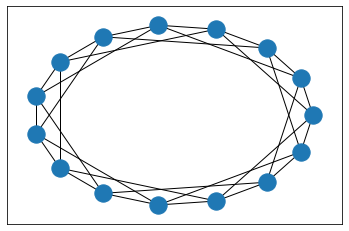

In [1]:
import networkx as nx

num_nodes = 15
weight = 1
nn_edges = [(i, (i + 1) % num_nodes, weight) for i in range(num_nodes)]
n3_edges = [(i, (i + 3) % num_nodes, -weight) for i in range(num_nodes)]

graph = nx.Graph()
graph.add_weighted_edges_from(nn_edges)
graph.add_weighted_edges_from(n3_edges)

pos = nx.circular_layout(graph)
nx.draw_networkx(graph, with_labels=False, pos=pos)

## Construct quadratic program

We can use Qiskit's Optimization module to construct a QUBO based on the graph.

In [2]:
from qiskit_optimization.applications import Maxcut

maxcut = Maxcut(graph)

In [3]:
quadratic_program = maxcut.to_quadratic_program()
print(quadratic_program.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 + 2*x_0*x_12 - 2*x_0*x_14 + 2*x_0*x_3 + 2*x_1*x_13 - 2*x_1*x_2
  + 2*x_1*x_4 - 2*x_10*x_11 + 2*x_10*x_13 - 2*x_11*x_12 + 2*x_11*x_14
  - 2*x_12*x_13 - 2*x_13*x_14 + 2*x_2*x_14 - 2*x_2*x_3 + 2*x_2*x_5 - 2*x_3*x_4
  + 2*x_3*x_6 - 2*x_4*x_5 + 2*x_4*x_7 - 2*x_5*x_6 + 2*x_5*x_8 - 2*x_6*x_7
  + 2*x_6*x_9 + 2*x_7*x_10 - 2*x_7*x_8 + 2*x_8*x_11 - 2*x_8*x_9 - 2*x_9*x_10
  + 2*x_9*x_12

Subject to
  No constraints

  Binary variables (15)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9 x_10 x_11 x_12 x_13 x_14



## Classical reference solution

This is a standard formulation of a QUBO, and before getting into the Quantum Algorithms, let's use a classical algorithm to obtain a reference solution.

In [4]:
from qiskit_optimization.algorithms import CplexOptimizer

cplex = CplexOptimizer()
reference = cplex.solve(quadratic_program)

-- cannot find parameters matching version: 22.1.1.0, using: 20.1.0.0


In [5]:
print("Solution:", reference.x)
print("Cut value:", reference.fval)

Solution: [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
Cut value: 10.0


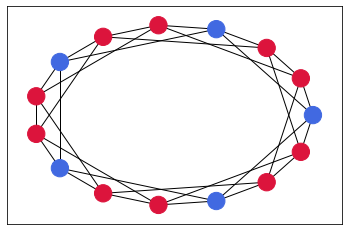

In [6]:
pos = nx.circular_layout(graph)
node_color = ["crimson" if value == 0 else "royalblue" for value in reference.x]
nx.draw_networkx(graph, with_labels=False, pos=pos, node_color=node_color)

## Solve using a quantum computer

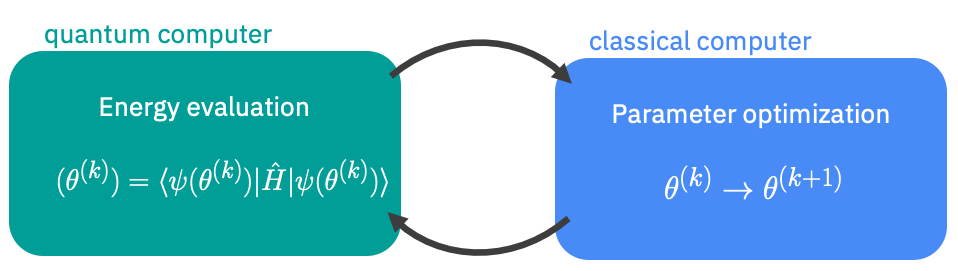

Ingredients:
- a Hamiltonian $H$ whose energy we minimize
- a variational model $|\psi(\theta)\rangle$ for $\theta \in \mathbb{R}^d$
- a classical optimization routine

### Convert QUBO to Ising Hamiltonian

As first step, we need to convert the problem into a language that the Quantum Computer understand. To do that, we'll convert the QUBO into an Ising Hamiltonian. This could be done manually -- or we can leverage Qiskit Optimization:

In [7]:
hamiltonian, offset = quadratic_program.to_ising()

In [8]:
print(hamiltonian)

0.5 * IIIIIIIIIIIIIZZ
+ 0.5 * IIIIIIIIIIIIZZI
- 0.5 * IIIIIIIIIIIZIIZ
+ 0.5 * IIIIIIIIIIIZZII
- 0.5 * IIIIIIIIIIZIIZI
+ 0.5 * IIIIIIIIIIZZIII
- 0.5 * IIIIIIIIIZIIZII
+ 0.5 * IIIIIIIIIZZIIII
- 0.5 * IIIIIIIIZIIZIII
+ 0.5 * IIIIIIIIZZIIIII
- 0.5 * IIIIIIIZIIZIIII
+ 0.5 * IIIIIIIZZIIIIII
- 0.5 * IIIIIIZIIZIIIII
+ 0.5 * IIIIIIZZIIIIIII
- 0.5 * IIIIIZIIZIIIIII
+ 0.5 * IIIIIZZIIIIIIII
- 0.5 * IIIIZIIZIIIIIII
+ 0.5 * IIIIZZIIIIIIIII
- 0.5 * IIIZIIZIIIIIIII
+ 0.5 * IIIZZIIIIIIIIII
- 0.5 * IIZIIIIIIIIIIIZ
- 0.5 * IIZIIZIIIIIIIII
+ 0.5 * IIZZIIIIIIIIIII
- 0.5 * IZIIIIIIIIIIIZI
- 0.5 * IZIIZIIIIIIIIII
+ 0.5 * IZZIIIIIIIIIIII
+ 0.5 * ZIIIIIIIIIIIIIZ
- 0.5 * ZIIIIIIIIIIIZII
- 0.5 * ZIIZIIIIIIIIIII
+ 0.5 * ZZIIIIIIIIIIIII


### Select a circuit ansatz

Qiskit's circuit library offers a variety of popular, pre-built circuits for variational optimization. Here we'll use the QAOA ansatz, a model developed for combinatorial optimization problems.

In [9]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(hamiltonian)

For the experts: The QAOA ansatz is motivated from quantum annealing, starting in a simple ground state and moving to the target ground state:

$$
    H(t) = \lambda(t) H_0 + (1 - \lambda(t)) H_\text{target}
$$

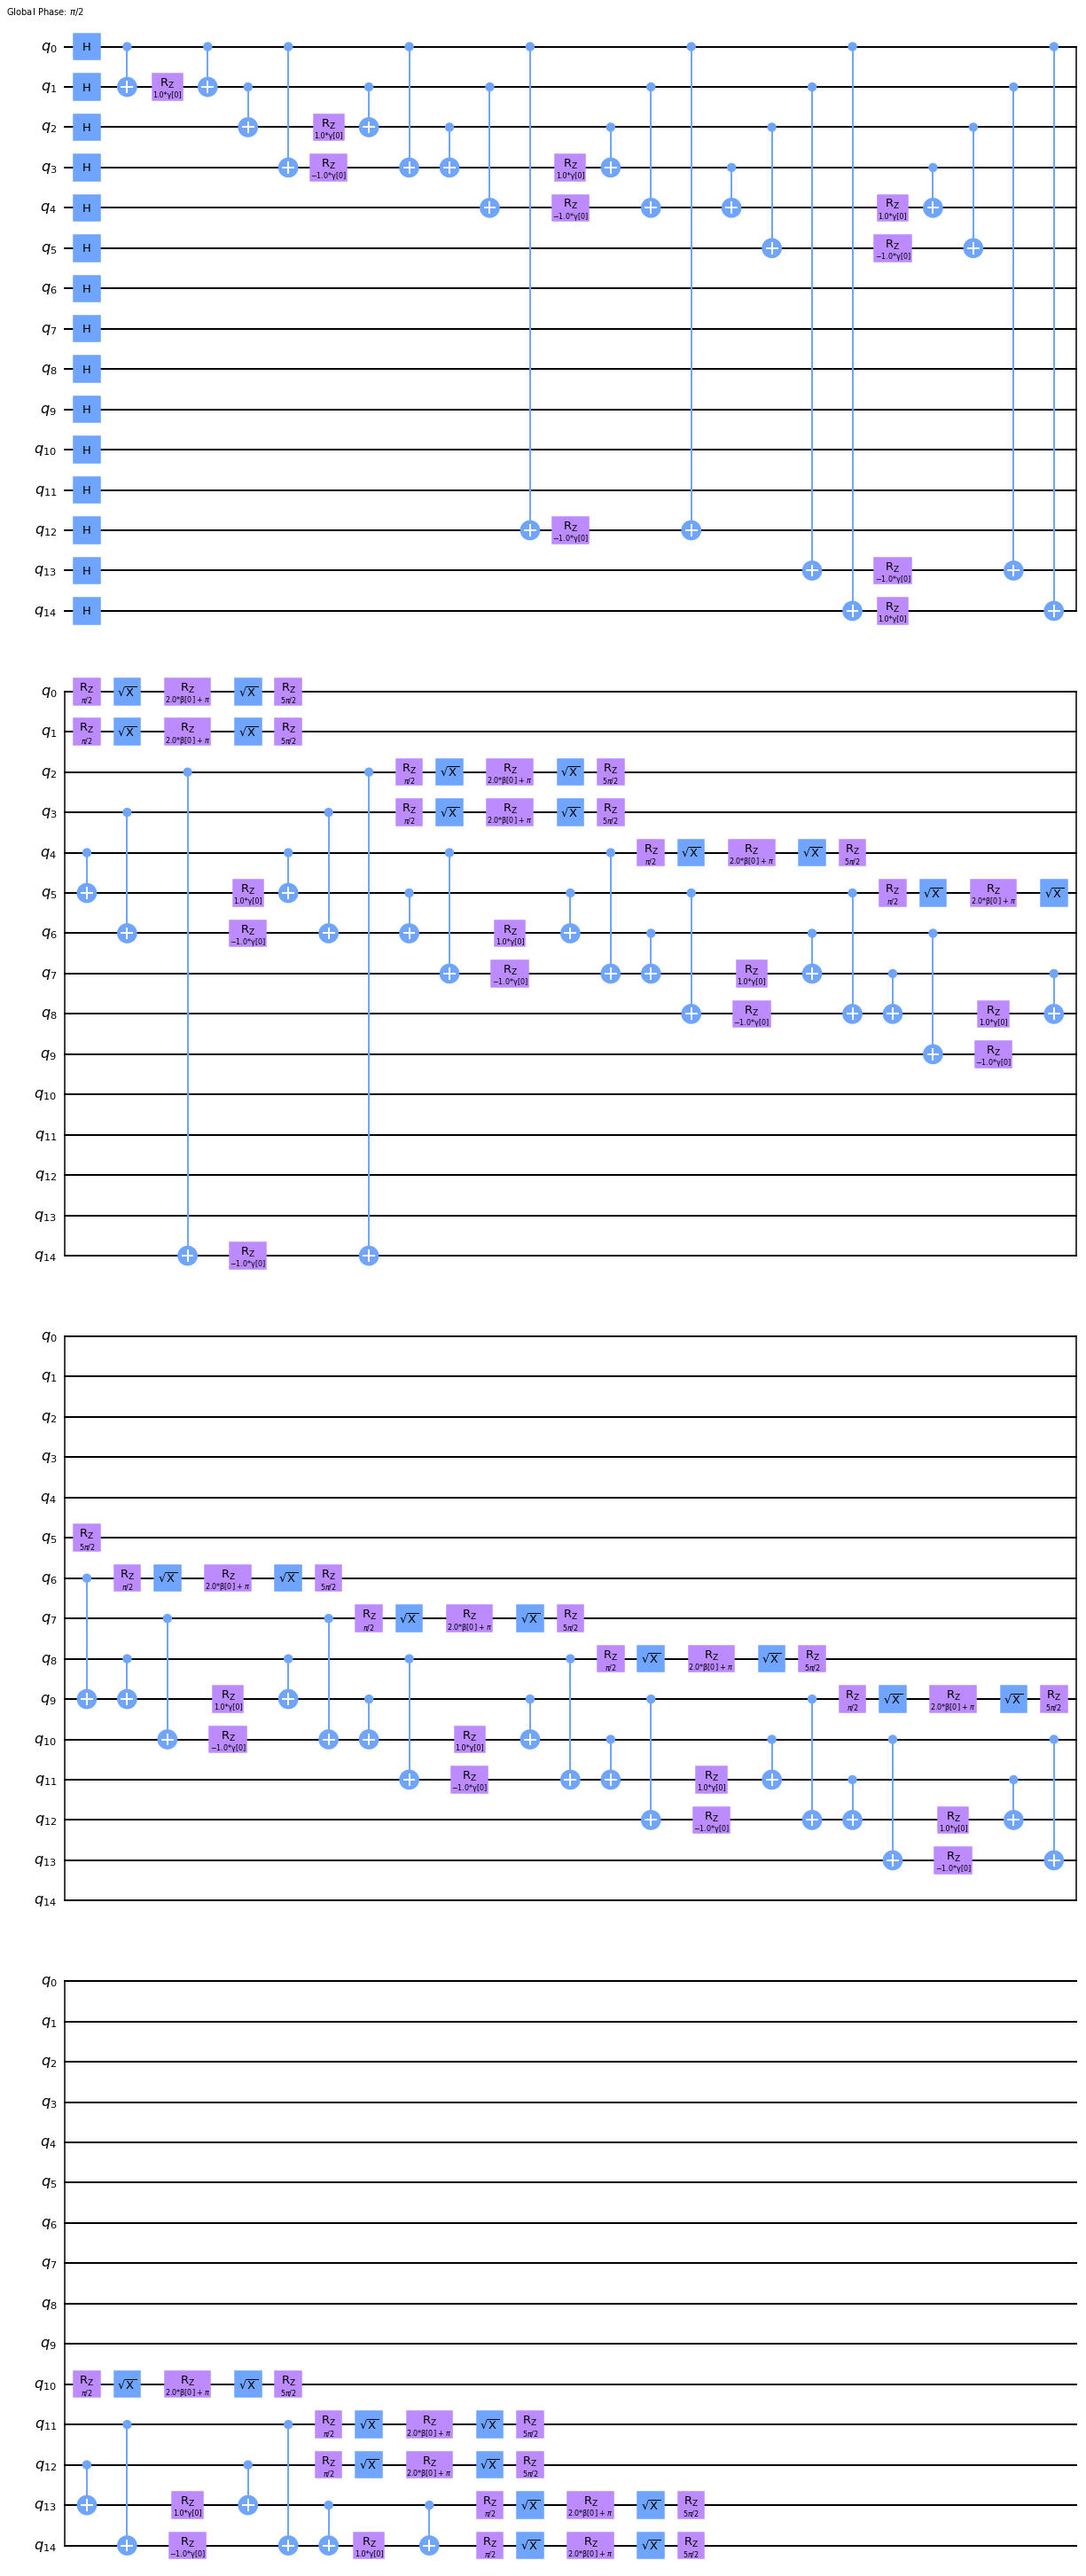

In [10]:
from qiskit.compiler import transpile

circuit = transpile(circuit, basis_gates=["h", "rz", "sx", "x", "cx"])
circuit.draw("mpl")

### Evaluate the energy 

A key operation on the quantum computer is the energy evaluation -- this is the cost function we aim to minimize:

$$
    E(\theta) = \langle \psi(\theta) | H | \psi(\theta)\rangle
$$

In Qiskit, this is done using an `Estimator` computational primitive. 

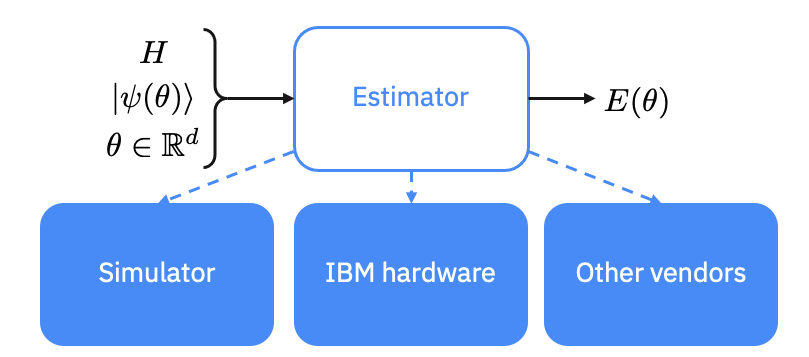

In [11]:
from qiskit_aer.primitives import Estimator

estimator = Estimator(run_options={"shots": 10_000}, approximation=True)

def evaluate_energy(parameters, maximize=False):
    job = estimator.run(circuit, hamiltonian, parameters)
    result = job.result()
    sign = -1 if maximize else 1
    return sign * result.values[0].real

In [12]:
evaluate_energy([1, 1])

-1.5115073178855842

In [13]:
for _ in range(3):
    print(evaluate_energy([1, 1]))

-1.483561721569675
-1.497569133841502
-1.5061190853749993


### Choose a classical optimization

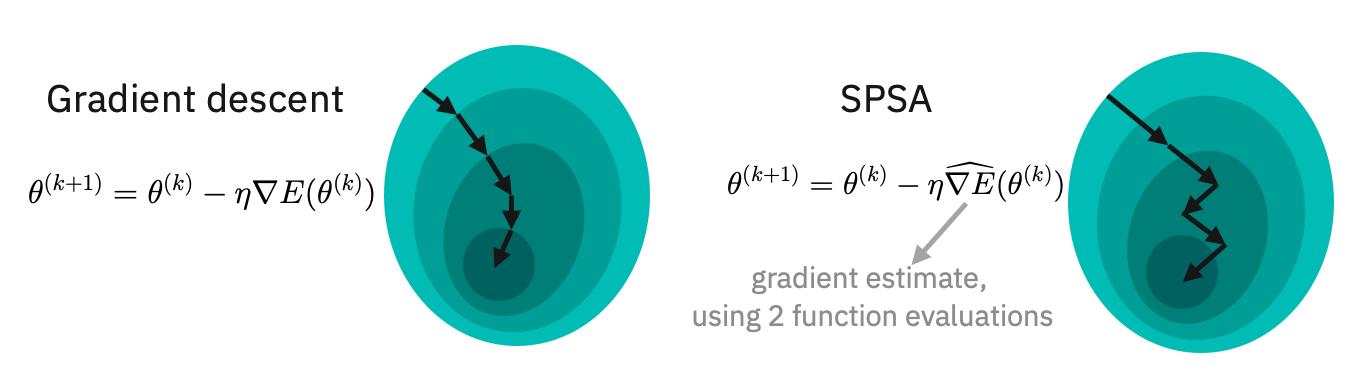

In [14]:
from qiskit.algorithms.optimizers import SPSA

In [15]:
energies = []

def log_energies(*args):
    energies.append(args[2])

optimizer = SPSA(maxiter=200, learning_rate=1e-3, perturbation=1e-2, callback=log_energies)

### Run the optimization

In [16]:
initial_guess = [0, 0]  # start in ground state of simple Hamiltonian
result = optimizer.minimize(evaluate_energy, initial_guess)

Now we can plot the tracked energies:

Text(0, 0.5, 'energy')

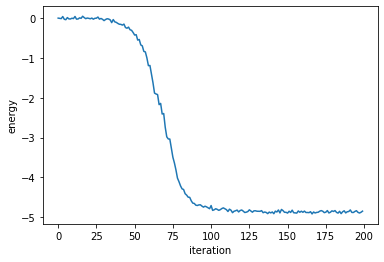

In [17]:
import matplotlib.pyplot as plt
plt.plot(energies)
plt.xlabel("iteration")
plt.ylabel("energy")

And these are the optimized parameters:

In [18]:
result.x

array([-0.39243631,  0.52416049])

### Evaluate the final state

As result, we have a state that encodes the optimal solutions.

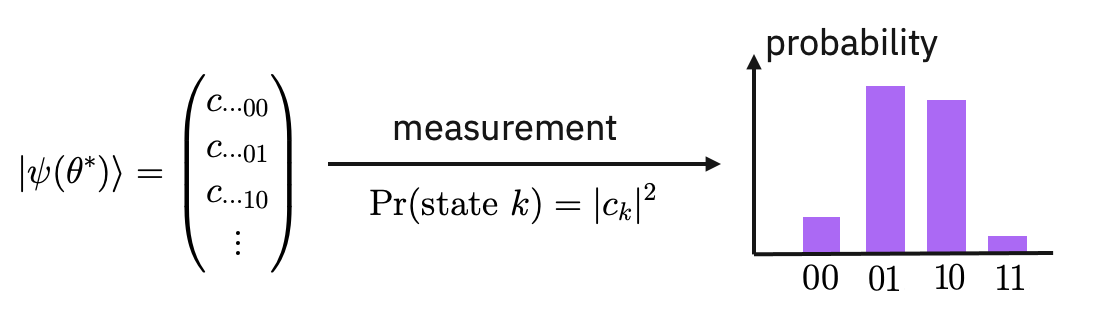

In [19]:
from qiskit.primitives import Sampler

circuit.measure_all()

sampler = Sampler(options={"shots": 10_000})
sampled = sampler.run(circuit, result.x).result().quasi_dists[0]

We sampled many states!

In [20]:
sampled

{4: 0.0001,
 10: 0.0001,
 13: 0.0001,
 18: 0.0001,
 21: 0.0001,
 27: 0.0001,
 37: 0.0001,
 41: 0.0001,
 42: 0.0001,
 44: 0.0001,
 45: 0.0001,
 73: 0.0005,
 74: 0.0004,
 77: 0.0001,
 80: 0.0001,
 81: 0.0001,
 90: 0.0001,
 109: 0.0001,
 139: 0.0001,
 144: 0.0002,
 146: 0.0004,
 148: 0.0001,
 150: 0.0001,
 153: 0.0001,
 165: 0.0001,
 171: 0.0001,
 173: 0.0002,
 180: 0.0001,
 237: 0.0001,
 242: 0.0001,
 276: 0.0001,
 288: 0.0001,
 292: 0.0001,
 296: 0.0001,
 298: 0.0001,
 301: 0.0001,
 308: 0.0001,
 309: 0.0001,
 329: 0.0001,
 330: 0.0001,
 361: 0.0001,
 362: 0.0002,
 402: 0.0001,
 424: 0.0001,
 429: 0.0001,
 434: 0.0001,
 476: 0.0001,
 544: 0.0001,
 548: 0.0001,
 564: 0.0001,
 584: 0.0002,
 585: 0.0001,
 586: 0.0002,
 590: 0.0001,
 595: 0.0001,
 600: 0.0001,
 616: 0.0001,
 618: 0.0001,
 620: 0.0002,
 640: 0.0001,
 676: 0.0001,
 680: 0.0001,
 682: 0.0001,
 698: 0.0001,
 712: 0.0001,
 724: 0.0001,
 730: 0.0001,
 777: 0.0001,
 806: 0.0001,
 819: 0.0001,
 840: 0.0001,
 852: 0.0001,
 870: 0.00

... but we are interested in the most likely ones, which should be the best solutions (if the optimization worked).

In [21]:
all_states = list(sampled.binary_probabilities().items())
sorted_states = sorted(all_states, key=lambda item: item[1], reverse=True)

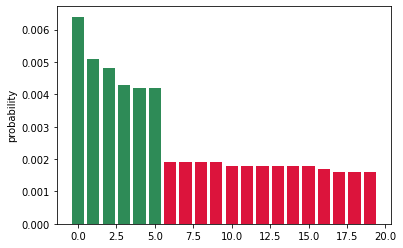

In [22]:
m = 20
colors = []
for state, _ in sorted_states[:m]:
    as_list = list(map(int, state))
    value = quadratic_program.objective.evaluate(as_list)
    colors.append("seagreen" if value == 10 else "crimson")
    
plt.bar(range(m), [prob for _, prob in sorted_states[:m]], color=colors)
plt.ylabel("probability");

We can also plot all 6 most likely states:

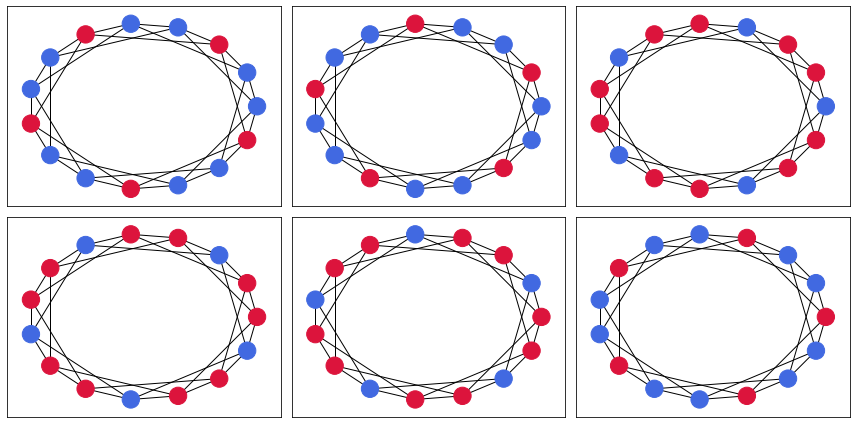

In [23]:
_, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, (state, _) in enumerate(sorted_states[:6]):
    ax = axs[i // 3, i % 3]
    node_color = ["crimson" if bit == "0" else "royalblue" for bit in state]
    nx.draw_networkx(graph, with_labels=False, pos=pos, node_color=node_color, ax=ax)
    
plt.tight_layout()

### ... or just use Qiskit to do all the above

In [24]:
from qiskit_aer.primitives import Sampler
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE

sampler = Sampler(run_options={"shots": 1000})
vqe = SamplingVQE(sampler=sampler, ansatz=circuit, optimizer=optimizer, initial_point=initial_guess)

In [25]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer

quantum_optimization = MinimumEigenOptimizer(vqe)
opt_result = quantum_optimization.solve(quadratic_program)

In [26]:
print("Solution:", opt_result.x)
print("Cut value:", opt_result.fval)

Solution: [1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1.]
Cut value: 10.0


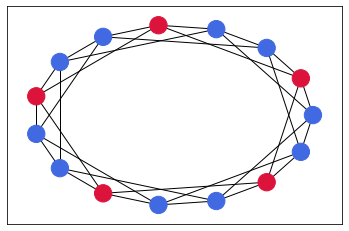

In [27]:
node_color = ["crimson" if value == 0 else "royalblue" for value in opt_result.x]
nx.draw_networkx(graph, with_labels=False, pos=pos, node_color=node_color)